## Big data analytics: Big Data Bowl 
Authored by Jason Maloney and Jesse Pezzillo

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
#import warnings; warnings.simplefilter('ignore')

In [2]:
# This dataset can be downloaded from https://www.kaggle.com/c/nfl-big-data-bowl-2020/data after an agreement is digitally signed through kaggle. 
data = pd.read_csv('train.csv')
#lower all columns
data.columns = map(str.lower, data.columns)

#### View the data and types

In [3]:
print(data.dtypes)

gameid                      int64
playid                      int64
team                       object
x                         float64
y                         float64
s                         float64
a                         float64
dis                       float64
orientation               float64
dir                       float64
nflid                       int64
displayname                object
jerseynumber                int64
season                      int64
yardline                    int64
quarter                     int64
gameclock                  object
possessionteam             object
down                        int64
distance                    int64
fieldposition              object
homescorebeforeplay         int64
visitorscorebeforeplay      int64
nflidrusher                 int64
offenseformation           object
offensepersonnel           object
defendersinthebox         float64
defensepersonnel           object
playdirection              object
timehandoff   

In [4]:
data.head()

,gameid,playid,team,x,y,s,a,dis,orientation,dir,...,week,stadium,location,stadiumtype,turf,gameweather,temperature,humidity,windspeed,winddirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


#### Player height

In [5]:
# create function to convert playerHeight to inches
def heightToInches(x):
    try:
        x,x1 = x.split('-')
        x = int(x)
        x1 = int(x1)
        x = (12*x) + x1
        return(x)
    except:
        return int(x*12)

In [6]:
# run function over column
data["playerheight"] = data["playerheight"].apply(heightToInches)

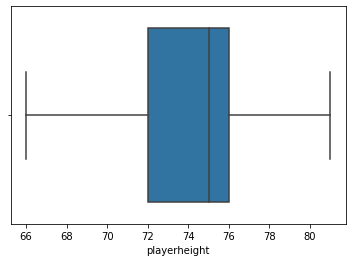

In [7]:
sns.boxplot(data["playerheight"])
plt.show()

#### Player age

In [8]:
# convert TimeHandoff to dates and times
data['timehandoff'] = pd.to_datetime(data['timehandoff'])
data['timesnap'] = pd.to_datetime(data['timesnap'])
data['playerbirthdate'] = pd.to_datetime(data["playerbirthdate"])
# confirm dtype
print('handoff time:',data["timehandoff"].dtype)
print('snap time:',data["timesnap"].dtype)
print('playerbirthdate',data["playerbirthdate"].dtype)

handoff time: datetime64[ns, UTC]
snap time: datetime64[ns, UTC]
playerbirthdate datetime64[ns]


In [9]:
# generate age of each player
def birthDayCalc(df):
    birthDay = df[0].year
    timeHandoff = df[1].year
    age = (timeHandoff - birthDay) 
    return age
data["age"] = data[["playerbirthdate","timehandoff"]].apply(birthDayCalc, axis=1)

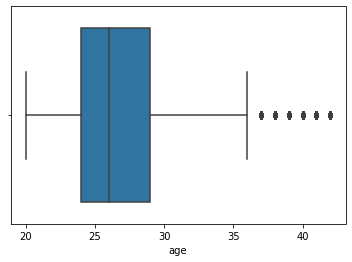

Player anomolies/Old dudes:


array(['Tom Brady', 'Josh McCown', 'Benjamin Watson', 'James Harrison',
       'Carson Palmer', 'Julius Peppers', 'Drew Brees', 'Terence Newman',
       'Antonio Gates', 'Dwight Freeney', 'Mike Adams', 'Philip Rivers',
       'Karlos Dansby', 'Eli Manning', 'Andrew Whitworth', 'Matt Schaub',
       'Cameron Wake', 'Ryan Fitzpatrick', 'Jason Peters',
       'Terrell Suggs', 'Jason Witten', 'Ben Roethlisberger'],
      dtype=object)

In [10]:
sns.boxplot(data["age"])
plt.show()
print("Player anomolies/Old dudes:")
data['displayname'][data["age"] > 36].unique()

#### Windspeed

In [11]:
# convert windspeed
def windConvert(x):
    try:
        x = re.match('[0-9]+',x)
        x = x.groups()
        for i in x:
            y += i
            return(y)
    except:
        return(x)
data["windspeed"] = data["windspeed"].apply(windConvert)
# set NAN to 0
#data["windspeed"] = data["windspeed"].fillna(value=0)
# set to integer
# data["windspeed"] = data["windspeed"].astype(int)

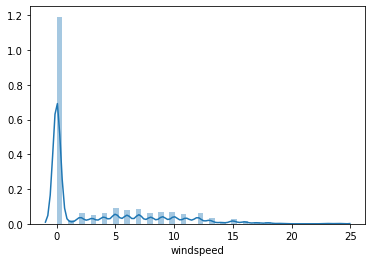

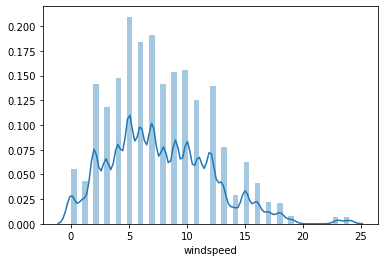

In [12]:
# plot with na's set to 0
sns.distplot(data["windspeed"].fillna(value=0))
plt.show()
# plot with no na's
sns.distplot(data["windspeed"].dropna())
plt.show()

In [13]:
# create a rusher dummy variable
data['rusher'] = 0
data['rusher'][data['nflid'] == data['nflidrusher']] = 1

#### Orientation and Direction

In [14]:
# create functions to fix oreintation and direction
# Refrenced this notebook to help understand how to modify https://www.kaggle.com/ben519/understanding-x-y-dir-and-orientation
def fixDir(x):
    y = (360-x+90) % 360
    return y
def fixOri(x):
    y = (360-x) % 360
    return y

In [15]:
# apply oreintation fix
data["orientation"][data["season"] == 2017] = data["orientation"][data["season"] == 2017].apply(fixOri)
# apply direction fix
data["dir"] = data["dir"].apply(fixDir)

#### Distance to the Rusher

In [16]:
# get Rusher X and Y
pos_df = pd.DataFrame(zip(data['x'][data['rusher'] == 1], data['y'][data['rusher'] == 1]), columns = ['x', 'y'])
pos_df.head()

,x,y
0,78.75,30.53
1,71.07,27.16
2,48.66,19.11
3,15.53,25.36
4,29.99,27.12


In [17]:
# need to get each value repeated 22 times, for each player in each play
posdf = pd.DataFrame(zip(pos_df['x'].repeat(22), pos_df['y'].repeat(22)), index = range(len(data)), columns = ['rushx', 'rushy'])
# put the rushX and rushY in the main df
data['rushx'] = posdf['rushx']
data['rushy'] = posdf['rushy']
del posdf # delete df to save memory

In [18]:
# euclidean dist = sqrt((x1 - x2)^2 + (y1 - y2)^2) - straight line distance
data['disttorush'] = np.sqrt((data['x'] - data['rushx'])**2 + (data['y'] - data['rushy'])**2)
data.head()

,gameid,playid,team,x,y,s,a,dis,orientation,dir,...,gameweather,temperature,humidity,windspeed,winddirection,age,rusher,rushx,rushy,disttorush
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,278.01,272.82,...,Clear and warm,63.0,77.0,8.0,SW,29,0,78.75,30.53,6.480872
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,332.39,251.30,...,Clear and warm,63.0,77.0,8.0,SW,28,0,78.75,30.53,4.593310
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,356.99,247.27,...,Clear and warm,63.0,77.0,8.0,SW,28,0,78.75,30.53,5.448982
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,0.23,344.36,...,Clear and warm,63.0,77.0,8.0,SW,35,0,78.75,30.53,7.820038
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,347.37,285.69,...,Clear and warm,63.0,77.0,8.0,SW,30,0,78.75,30.53,10.622476


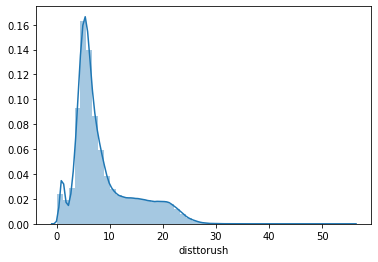

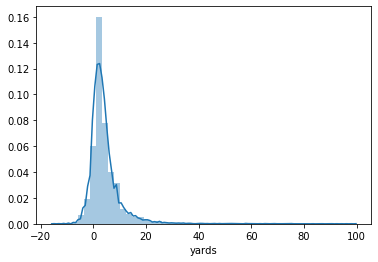

In [19]:
# distribution of players' distance to rusher
sns.distplot(data['disttorush'][data['rusher'] == 0])
plt.show()

# distribution of yards gained/play
sns.distplot(data['yards'])
plt.show()

#### Offensive and Defensive Personnel 

In [20]:
# count defensive position
# differentiate defensive ol and offensive ol - JM
data["ol_d"] = data["defensepersonnel"].str.extract(pat="([1-9] OL)")
data["ol_d"] = data["ol_d"].str.extract(pat="([1-9])")
data["dl"] = data["defensepersonnel"].str.extract(pat="([1-9] DL)")
data["dl"] = data["dl"].str.extract(pat="([1-9])")
data["lb"] = data["defensepersonnel"].str.extract(pat="([1-9] LB)")
data["lb"] = data["lb"].str.extract(pat="([1-9])")
data["db"] = data["defensepersonnel"].str.extract(pat="([1-9] DB)")
data["db"] = data["db"].str.extract(pat="([1-9])")
# differentiate defensive rb and offensive rb - JM
data["rb_d"] = data["defensepersonnel"].str.extract(pat="([1-9] RB)")
data["rb_d"] = data["rb_d"].str.extract(pat="([1-9])")

In [21]:
# count offensive position
# QB, OL, RB, TE, WR, DL, LB, DB
data['qb'] = data['offensepersonnel'].str.extract(pat='([1-9] QB)')
data['qb'] = data['qb'].str.extract(pat='([1-9])')
data['ol'] = data['offensepersonnel'].str.extract(pat='([1-9] OL)')
data['ol'] = data['ol'].str.extract(pat='([1-9])')
data['rb'] = data['offensepersonnel'].str.extract(pat='(\d RB)')
data['rb'] = data['rb'].str.extract(pat='(\d)')
data['te'] = data['offensepersonnel'].str.extract(pat='(\d TE)')
data['te'] = data['te'].str.extract(pat='(\d)')
data['wr'] = data['offensepersonnel'].str.extract(pat='(\d WR)')
data['wr'] = data['wr'].str.extract(pat='(\d)')
# differentiate offensive dl - JM
data['dl_o'] = data['offensepersonnel'].str.extract(pat='(\d DL)')
data['dl_o'] = data['dl_o'].str.extract(pat='(\d)')
data['lb_o'] = data['offensepersonnel'].str.extract(pat='(\d LB)')
data['lb_o'] = data['lb_o'].str.extract(pat='(\d)')
data['db_o'] = data['offensepersonnel'].str.extract(pat='(\d DB)')
data['db_o'] = data['db_o'].str.extract(pat='(\d)')

In [22]:
# replace nas with 0
data['ol'].fillna(0, inplace = True)
data['dl'].fillna(0, inplace = True)
data['db'].fillna(0, inplace = True)
data['lb'].fillna(0, inplace = True)
data['rb'].fillna(0, inplace = True)
data['ol_d'].fillna(0, inplace = True)
data['rb_d'].fillna(0, inplace = True)
data['te'].fillna(0, inplace = True)
data['wr'].fillna(0, inplace = True)
data['dl_o'].fillna(0, inplace = True)
data['lb_o'].fillna(0, inplace = True)
data['db_o'].fillna(0, inplace = True)
# replace qb nas with 1 - WILDCAT has a qb, but the ball is snapped to someone else - JM
data['qb'].fillna(1, inplace = True)

In [23]:
# set ol == 0 to be 11 - sum(offensive personnel)
off = ['rb', 'qb', 'te', 'wr', 'dl_o', 'lb_o', 'db_o'] 
data[off] = data[off].astype(str).astype(int)
data['ol'][data['ol'] == 0] = 11 - data[off].sum(axis = 1)

In [24]:
# convert rest of personnel to int
defp = ['dl', 'lb', 'rb_d', 'ol_d', 'db']
data[defp] = data[defp].astype(str).astype(int)
# fill lb na with 11 - sum(everyone else on defense)
data['lb'][data['lb'] == 0] = 11 - data[defp].sum(axis = 1)

In [25]:
data[13109:131114]

,gameid,playid,team,x,y,s,a,dis,orientation,dir,...,db,rb_d,qb,ol,rb,te,wr,dl_o,lb_o,db_o
13109,2017091100,20170911001375,home,11.24,23.79,2.01,0.47,0.25,327.89,254.16,...,5,0,1,5,1,1,3,0,0,0
13110,2017091100,20170911001375,home,10.57,37.71,0.02,0.04,0.00,351.54,226.16,...,5,0,1,5,1,1,3,0,0,0
13111,2017091100,20170911001375,home,16.84,35.15,1.62,2.13,0.26,253.33,282.32,...,5,0,1,5,1,1,3,0,0,0
13112,2017091100,20170911001543,away,86.15,30.79,0.52,1.04,0.10,176.06,17.13,...,5,0,1,5,1,1,3,0,0,0
13113,2017091100,20170911001543,away,91.23,30.00,1.98,0.50,0.24,103.77,358.09,...,5,0,1,5,1,1,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131109,2017110507,20171105073302,home,49.38,33.99,3.50,0.34,0.37,345.52,97.33,...,5,0,1,5,1,1,3,0,0,0
131110,2017110507,20171105073302,home,46.75,16.97,1.81,2.11,0.18,44.15,141.82,...,5,0,1,5,1,1,3,0,0,0
131111,2017110507,20171105073302,home,51.33,35.73,1.48,1.54,0.25,313.68,64.10,...,5,0,1,5,1,1,3,0,0,0
131112,2017110507,20171105073302,home,52.54,28.53,5.70,2.73,0.63,83.65,78.36,...,5,0,1,5,1,1,3,0,0,0


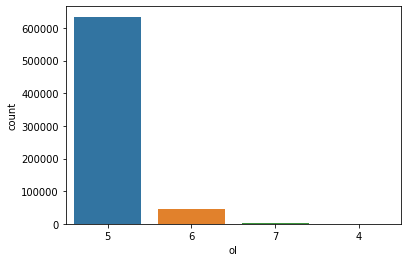

In [26]:
# distritbution of ol/play
sns.countplot(data['ol'])

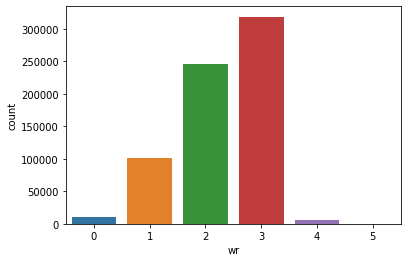

<function matplotlib.pyplot.show(*args, **kw)>

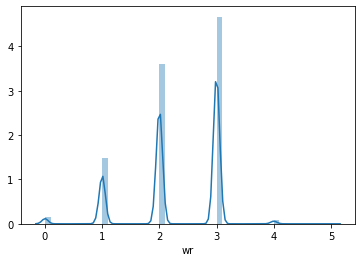

In [27]:
# distribution of wr/play
sns.countplot(data['wr'])
plt.show()

sns.distplot(data['wr'])
plt.show

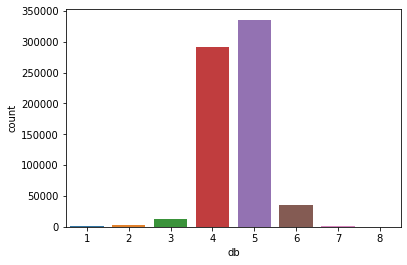

In [28]:
# distribution of db/play
sns.countplot(data['db'])

### Reshape dataframe

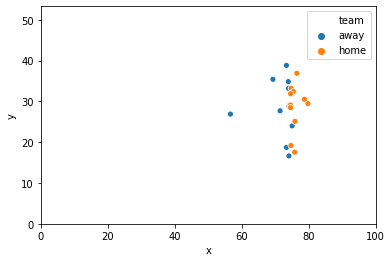

In [29]:
# explore one play visually
# influcenced by https://www.kaggle.com/statsbymichaellopez/nfl-tracking-wrangling-voronoi-and-sonars
# select one play
plot = data[data["playid"] == 20170907000118]
# plot using seaborn
sns.scatterplot(data=plot,x="x",y="y",hue="team")
# set football field dimensions
plt.xlim(0,100)
plt.ylim(0,53.3)
# show plot
plt.show()
del plot

In [30]:
# this function sets what team the player is on
def teamIdentitySet(x):
    if x["team"] == "home":
        return x["hometeamabbr"]
    else:
        return x["visitorteamabbr"]
# applying function entire data df
data["teamidentity"] = data.apply(teamIdentitySet, axis=1)

In [31]:
#  create row called yards from own goal
def createYardsFromOwnGoal(x):
    # if the ball is on the possession teams side, just return yardline
    if x["fieldposition"] == x["possessionteam"]:
        return x["yardline"]
    else:
    # if the ball is not on the possesion team side, convert
        return (50 + (50-x["yardline"]))
data["yardfromowngoal"] = data.apply(createYardsFromOwnGoal,axis=1)

In [32]:
def standardizeXCoordinates(x):
    if x["playdirection"] == "left":
        return 120 - x["x"]
    else:
        return x["x"]
def standardizeYCoordinates(x):
    if x["playdirection"] == "left":
        return 160/3 - x["y"]
    else:
        return x["y"]

In [33]:
data["x_standard"] = data.apply(standardizeXCoordinates,axis=1)
data["y_standard"] = data.apply(standardizeYCoordinates, axis=1)

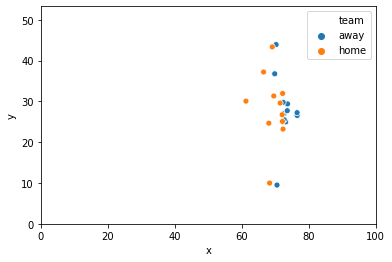

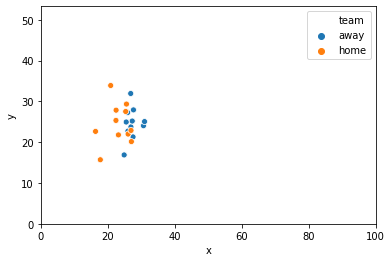

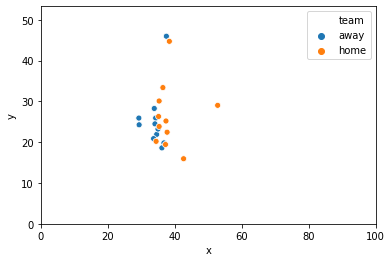

In [34]:
# generate a few more outputs graphed 
# explore one play visually
# influcenced by https://www.kaggle.com/statsbymichaellopez/nfl-tracking-wrangling-voronoi-and-sonars
# select one play
def plotPlay(x):
    plot = data[data["playid"] == x]
    sns.scatterplot(data=plot,x="x",y="y",hue="team")
    plt.xlim(0,100)
    plt.ylim(0,53.3)
    plt.show()
    del plot

plotPlay(20191125003789)
plotPlay(20170910022619)
plotPlay(20190922041421)

In [35]:
data.head()

,gameid,playid,team,x,y,s,a,dis,orientation,dir,...,rb,te,wr,dl_o,lb_o,db_o,teamidentity,yardfromowngoal,x_standard,y_standard
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,278.01,272.82,...,1,1,3,0,0,0,KC,35,36.09,18.493333
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,332.39,251.30,...,1,1,3,0,0,0,KC,35,35.33,20.693333
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,356.99,247.27,...,1,1,3,0,0,0,KC,35,36.00,20.133333
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,0.23,344.36,...,1,1,3,0,0,0,KC,35,38.54,25.633333
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,347.37,285.69,...,1,1,3,0,0,0,KC,35,40.68,17.913333


In [36]:
# Thoughts on reshaping this mutha
# could we generate features that are more global in nature, then flatten by unique play?
### Step1 - Create feature using 22 players, or single players. 
### Step2 - Flatten by playid
### Step3 - Run model

### Modeling

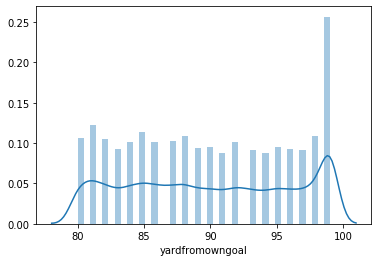

In [41]:
# flatten + subset
mdata = data.drop_duplicates("playid")
redzone = data[data["yardfromowngoal"] >= 80]
sns.distplot(redzone['yardfromowngoal'])
plt.show()

In [42]:
# train with model
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import cross_val_score
#x.select_dtypes([np.number]).head()
cols_to_drop = ['gameid', 'playid', 'x', 'y', 'orientation', 'dir', 'nflid',
               'jerseynumber', 'season', 'nflidrusher', 'week', 'yards',
               'temperature', 'humidity', 'windspeed']
# define prediction and output
y = redzone['yards']
x = redzone.drop(cols_to_drop, axis = 1)

# one-hot encoding
x = pd.get_dummies(x)

# get only numeric variables
x = x.select_dtypes([np.number])
x = x.fillna(0)

n_plays = 80 # number of plays in the train set

cutoff = int(len(data)/22*0.8) * 22 - 1
print(cutoff)
Xtrain, Xtest, ytrain, ytest = x[:cutoff], x[cutoff:], y[:cutoff], y[cutoff:]

clf = rfc(n_estimators = 100)
clf.fit(Xtrain, ytrain)

scores = cross_val_score(clf, x, y, cv = 3)
print(scores.mean())

545709
0.18768769742659308


In [43]:

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import cross_val_score
#x.select_dtypes([np.number]).head()
cols_to_drop = ['gameid', 'playid', 'x', 'y', 'orientation', 'dir', 'nflid',
               'jerseynumber', 'season', 'nflidrusher', 'week', 'yards',
               'temperature', 'humidity', 'windspeed']
# define prediction and output
y = mdata['yards']
x = mdata.drop(cols_to_drop, axis = 1)

# one-hot encoding
x = pd.get_dummies(x)

# get only numeric variables
x = x.select_dtypes([np.number])
x = x.fillna(0)

n_plays = 80 # number of plays in the train set

cutoff = int(len(data)/22*0.8) * 22 - 1
print(cutoff)
Xtrain, Xtest, ytrain, ytest = x[:cutoff], x[cutoff:], y[:cutoff], y[cutoff:]

clf = rfc(n_estimators = 100)
clf.fit(Xtrain, ytrain)

scores = cross_val_score(clf, x, y, cv = 3)
print(scores.mean())

545709
0.12506867151158582


In [46]:
### TBD - Gotta figure out how to get rid of ... negatives????

#from sklearn.naive_bayes import MultinomialNB
#rng = np.random.RandomState(1)
#clf = MultinomialNB()
#clf.fit(x ,y)
#print(clf.predict(x))

ValueError: Negative values in data passed to MultinomialNB (input X)

In [57]:
pd.set_option("max_rows",100000)
x.lt(0).sum()




e_Outdoor Retr Roof-Open                                                               0
stadiumtype_Outdoors                                                                             0
stadiumtype_Outdor                                                                               0
stadiumtype_Outside                                                                              0
stadiumtype_Retr. Roof - Closed                                                                  0
stadiumtype_Retr. Roof - Open                                                                    0
stadiumtype_Retr. Roof Closed                                                                    0
stadiumtype_Retr. Roof-Closed                                                                    0
stadiumtype_Retr. Roof-Open                                                                      0
stadiumtype_Retractable Roof                                                                     0
stadiumtype_Retracta